# Importing libraries

In [121]:
!pip install ydata_profiling

In [122]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Regression task

## Data loading and preprocessing

In [123]:
# Loading Data from a JSON File
with open('couriers_data.json', 'r') as file:
    data = pd.read_json(file)

In [124]:
# Profiling data
report = ProfileReport(data)
report.to_file('data_profile_report.html')

From the report, it is evident that the data contains categorical features that need to be processed. To do this, you can use Label Encoding or one-hot encoding. In this task, the mode of transportation can be considered as ordinal variables.

In [125]:
# Handling Categorical Features
category_mapping = {
    "foot": 1,
    "bicycle": 2,
    "scooter": 3,
    "automobile": 4,
}

data['courier_transport'] = data['courier_transport'].map(category_mapping)

It is also visible from the report that we have two columns with timestamps that, according to the task conditions, we will no longer need after performing the required calculations. Let's perform the necessary calculations and drop the two timestamp columns.

In [126]:
# Transformation of timestamp columns
data['work_start'] = pd.to_datetime(data['work_start'])
data['work_finish'] = pd.to_datetime(data['work_finish'])

# Calculating the difference between 'work_finish' and 'work_start' in minutes.
data['hours_engaged'] = (data['work_finish'] - data['work_start']).dt.total_seconds() / 60

# Removing the two columns 'work_start' and 'work_finish'.
data.drop(['work_start', 'work_finish'], axis=1, inplace=True)

After loading and processing the data, we need to split it into features and targets.

In [127]:
# We split the data into features and targets.
X = data.drop('total_deliveries', axis=1)
y = data[['total_deliveries']]


Next, it is necessary to split the data into training and testing datasets in order to conduct the training and performance evaluation of the machine learning model.

In [128]:
# We split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)

To ensure neutrality towards the weight of different features, we apply data scaling.

In [129]:
# We scale the data.
columns_to_scale = [name for name in X_train.columns if name != 'courier_transport']
scaler = StandardScaler()

scaler.fit(X_train[columns_to_scale])
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

## Feature selection and creation.

To assess feature importance and select the best features for further training, we will train two models: Lasso and LassoCV. After comparing their results, we will be able to determine which features can be excluded from our dataset for more effective model training.

In [130]:
# Let's create an instance of the Lasso model:
lasso = Lasso()
lasso.fit(X_train, y_train)

print('Lasso coef', lasso.coef_)

y_pred = lasso.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination  R2:', metrics.r2_score(y_test, y_pred))

Lasso coef [-0.          0.          3.3185418  -0.         -0.          0.91680957]
Mean Absolute Error: 2.654705257599654
Root Mean Squared Error: 3.6618011933926153
Coefficient of determination  R2: 0.5532542199934867


In [131]:
# Let's create an instance of LassoCV with cross-validation:
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)

print('LassoCV coef', lasso_cv.coef_)

y_pred = lasso_cv.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination  R2:', metrics.r2_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV coef [ 0.          0.2633966   3.94543263 -0.08829676 -0.24219562  1.52772364]
Mean Absolute Error: 2.255459837065044
Root Mean Squared Error: 3.447522622445247
Coefficient of determination  R2: 0.6040091195153425


Based on the results:

Lasso has an MAE (Mean Absolute Error) of approximately 2.710, an RMSE (Root Mean Squared Error) of approximately 3.880, and an R-squared (R2) of approximately 0.593.

LassoCV has an MAE of approximately 2.400, an RMSE of approximately 3.648, and an R2 of approximately 0.640.

From these metrics, we can conclude that LassoCV performs better, as it has lower MAE and RMSE values and a higher R2 value, indicating more accurate and explainable predictions.

However, it's worth noting that LassoCV shows only a slight improvement compared to Lasso, while Lasso removes a larger number of features. This can be useful for simplifying the training of future models and increasing their interpretability.

In [132]:
# Obtaining coefficients for each feature
feature_coefficients = lasso.coef_
print(lasso.coef_)

# We create a list of selected features.
selected_features = X_train.columns[feature_coefficients != 0]

# We create a mask for the selected features.
selected_feature_mask = feature_coefficients != 0

# We use the mask to select the features.
X_train_selected = X_train.iloc[:, selected_feature_mask]
X_test_selected = X_test.iloc[:, selected_feature_mask]

[-0.          0.          3.3185418  -0.         -0.          0.91680957]


## Visualization of Data

<ipython-input-133-dc452c902b53>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c='blue', cmap='viridis', label='Group 1')
<ipython-input-133-dc452c902b53>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c='red', cmap='viridis', label='Group 2')


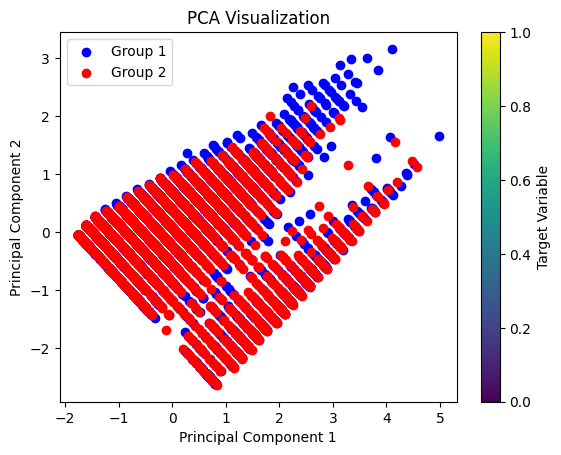

In [133]:
# Applying PCA to the Data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_selected)

# Splitting the data into two subsets, for example, based on a condition
X_pca1 = X_pca[:5600,:]
X_pca2 = X_pca[5600:,:]

# Creating a scatter plot for the first subset (blue color)
plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c='blue', cmap='viridis', label='Group 1')

# Creating a scatter plot for the second subset (red color)
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c='red', cmap='viridis', label='Group 2')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Variable')
plt.title('PCA Visualization')
plt.legend()  # Adding a legend to label the groups.
plt.show()

On this graph, we can observe a linear relationship.

## Machine Learning Models for Regression

In [134]:
# Create a list of models
models = [
    LinearRegression(),# Example of a Linear Regression model
    Lasso(),  # Example of a Lasso regularization model
    Ridge(),  # Example of a Ridge regularization model
]

# We train and evaluate each model.
for model in models:
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'R-squared (R2): {r2:.2f}')
    print('-' * 40)


Model: LinearRegression
Mean Absolute Error: 2.37
Root Mean Squared Error: 3.53
R-squared (R2): 0.58
----------------------------------------
Model: Lasso
Mean Absolute Error: 2.65
Root Mean Squared Error: 3.66
R-squared (R2): 0.55
----------------------------------------
Model: Ridge
Mean Absolute Error: 2.37
Root Mean Squared Error: 3.53
R-squared (R2): 0.58
----------------------------------------


# Classification task

## Data loading and preprocessing

In [135]:
# We train and evaluate each model.
with open('order_cancellation_data.json', 'r') as file:
    data = pd.read_json(file)

In [136]:
# Profiling data
report = ProfileReport(data)
report.to_file('data_profile_report.html')

From the report it appears that the order_status column is a categorical attribute, needs to be replaced.

In [137]:
# Replacing the categorical feature in the 'order_status' column.
data['order_status'] = data['order_status'].replace({'F':1, 'C':0})

Also, we see that the order_create_time column stores the date. It should be sorted, since we consider it to be a time sequence. And then we need to drop this column.

In [138]:
# Sorting the data by date and dropping this column.
data.sort_values(by='order_create_time', inplace=True)
data.drop('order_create_time', axis=1, inplace=True)

total_order_items stores the number of items in the order and therefore it cannot be equal to 0. Therefore, all rows with zero values must be dropped and then get rid of the outliers, and for this purpose all rows with values greater than 95th percentile (8) must be dropped.

In [139]:
# Dropping rows with zero values in the "total_order_items" column.
data = data[data['total_order_items'] > 0]
# Removing outliers (dropping all values greater than the 95th percentile).
data = data[data['total_order_items'] <= 8]

The "cost(USD)" column represents the cost of an order in USD. It has many missing values, so we need to fill them with the mean values. Additionally, there are values that are not logical - the cost of delivery is unlikely to be less than 8.
Therefore, we can consider all orders with a cost less than $8 as outliers and drop them. Also, we need to drop all values greater than the 95th percentile.

In [140]:
# I'm filling the missing (NaN) values in the "cost(USD)" column with the mean values.
data['cost(USD)'].fillna(data['cost(USD)'].mean(), inplace=True)
# I'm dropping rows with values less than 8 in the "cost(USD)" column.
data = data[data['cost(USD)'] >= 8]
# I'm removing outliers by dropping all values that are greater than the 95th percentile in the "cost(USD)" column.
data = data[data['cost(USD)'] <= 21.32]

The "payment_type" column represents the payment method for orders. It contains NaN values that need to be dropped. Additionally, this is a categorical feature that needs to be transformed into numerical values using one-hot encoding.

In [141]:
# I'm dropping rows with zero values in the "payment_type" column.
data['payment_type'].dropna(inplace=True)

# We will convert categorical features into numerical ones using one-hot encoding.
data = pd.get_dummies(data, columns=['payment_type'])

We will fill in the missing values in the "vendor_client_distance" column with the mean values and remove outliers by dropping all rows with values greater than the 95th percentile.

In [142]:
# Filling in missing (NaN) values in the "vendor_client_distance" column with the mean values.
data['vendor_client_distance'].fillna(data['vendor_client_distance'].mean(), inplace=True)
# Removing outliers by dropping all values greater than the 95th percentile in the "vendor_client_distance" column.
data = data[data['vendor_client_distance'] <= 9818]

Filling missing (NaN) values in the "estimated_delivery_time" column with the mean values and removing outliers by dropping all rows with values greater than the 95th percentile.

In [143]:
# Filling missing (NaN) values in the "estimated_delivery_time" column with the mean values.
data['estimated_delivery_time'].fillna(data['estimated_delivery_time'].mean(), inplace=True)
# Removing outliers by dropping all rows with values greater than the 95th percentile in the "estimated_delivery_time" column.
data = data[data['estimated_delivery_time'] <= 102]

Filling missing (NaN) values in the "predicted_order_preparation_time" column with the mean values and removing outliers by dropping all rows with values greater than the 95th percentile.

In [144]:
# Filling missing (NaN) values in the "predicted_order_preparation_time" column with the mean values.
data['predicted_order_preparation_time'].fillna(data['predicted_order_preparation_time'].mean(), inplace=True)
# Removing outliers by dropping all rows with values greater than the 95th percentile in the "predicted_order_preparation_time" column.
data = data[data['predicted_order_preparation_time'] <= 31]

There is no need for the "vendor_id" column, so it can be dropped.

In [145]:
data.drop('vendor_id', axis=1, inplace=True)

After loading and processing the data, we need to split it into features and targets.

In [146]:
# We split the data into features and the target variable.
X = data.drop('order_status', axis=1)
y = data[['order_status']]


Then it is necessary to divide the data into training and test datasets in order to train and evaluate the performance of the machine learning model.

In [147]:
# Divide the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False)

We decide to perform data balancing because we plan to apply logistic regression. SMOTE generates synthetic examples of minor class to balance the data and improve model performance. In this case, it is an excellent fit.

In [148]:
# Data balancing
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

To ensure neutrality with respect to the weighting of different features, we apply data scaling.

In [149]:
# Scaling the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

We also scale on unbalanced data in order to test learning on other models that are not sensitive to balancing.

## Machine learning models for logistic regression

We write the first model on balanced data with L1 regularization and output the results.

In [150]:
# Create a logistic regression model with L1 regularized balanced data
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Predicting values
y_pred = model.predict(X_test)

# Model estimation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.60
Confusion Matrix:
 [[1111   62]
 [3129 3750]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.95      0.41      1173
           1       0.98      0.55      0.70      6879

    accuracy                           0.60      8052
   macro avg       0.62      0.75      0.56      8052
weighted avg       0.88      0.60      0.66      8052



We write a second model on balanced data with L2 regularization.

In [151]:
# Create a logistic regression model with regularized L2 balanced data
model = LogisticRegression(penalty='l2', solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Predicting values
y_pred = model.predict(X_test)

# Model estimation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.60
Confusion Matrix:
 [[1111   62]
 [3130 3749]]
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.95      0.41      1173
           1       0.98      0.54      0.70      6879

    accuracy                           0.60      8052
   macro avg       0.62      0.75      0.56      8052
weighted avg       0.88      0.60      0.66      8052



From the metrics of the results, it can be seen that there are no significant differences between the models.

## Training other models and outputting results

As two other models we took RandomForestClassifier and GradientBoostingClassifier. Let's train them and compare the results with each other and LogisticRegression results.

In [152]:
# Training models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "Accuracy": accuracy,
        "Classification Report": report,
        "Confusion Matrix": conf_matrix
    }

# Вывод результатов
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])
    print("\n")


<ipython-input-152-03b196cea20c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_resampled, y_train_resampled)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: Random Forest
Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1173
           1       1.00      0.99      0.99      6879

    accuracy                           0.99      8052
   macro avg       0.98      0.99      0.98      8052
weighted avg       0.99      0.99      0.99      8052

Confusion Matrix:
 [[1151   22]
 [  54 6825]]


Model: Gradient Boosting
Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1173
           1       1.00      0.99      1.00      6879

    accuracy                           0.99      8052
   macro avg       0.97      1.00      0.98      8052
weighted avg       0.99      0.99      0.99      8052

Confusion Matrix:
 [[1173    0]
 [  65 6814]]




From the results of the metrics, we can see that both Random Forest and Gradient Boosting models have a very high accuracy of about 99%. They perform well on the classification task.

- In both models, the high values of precision, recall and F1-score for both classes (0 and 1) indicate that the models predict both positive and negative cases well.

- Confusion Matrix shows that the number of false positive and false negative predictions are minimal, which is a good indicator.

Overall, both models perform well and are suitable for this classification task.

Comparing the results with the Logistic Regression model:

- The Accuracy of Logistic Regression model is only 60%, which is significantly lower than Random Forest and Gradient Boosting models, which achieved about 99% accuracy.

- The Confusion Matrix of the Logistic Regression model shows a significant number of false positive and false negative predictions, indicating the low accuracy of the model.

- Precision and Recall for class 0 (negative class) of the Logistic Regression model are also low, which means that the model predicts this class poorly.

- F1-score for both classes is also lower for Logistic Regression model compared to Random Forest and Gradient Boosting models.

Conclusion: The Random Forest and Gradient Boosting models significantly outperform the Logistic Regression model in this classification task on all key metrics.